In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance




seed = 2023

## Basics

In [3]:
news = pd.read_csv("data/news.csv")

X = news.loc[:, ["text"]].to_numpy().flatten()
y = news.loc[:, ["label"]].to_numpy().flatten()
y = label_binarize(y, classes=["FAKE", "REAL"]).flatten() #0 = FAKE, 1 = REAL
y_text = news.loc[:, ["label"]].to_numpy().flatten()

In [4]:
news

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


### Encode Words as frequencies

In [5]:
# Word encoder: Goes through all news articles, counts occurences of distinct words keeps the most common 1000
X_count_vect = CountVectorizer(max_features=1000)
X_counts = X_count_vect.fit_transform(X)
# Transform to frequencies, corrected by in document frequency
X_tf = TfidfTransformer(use_idf=True).fit_transform(X_counts)

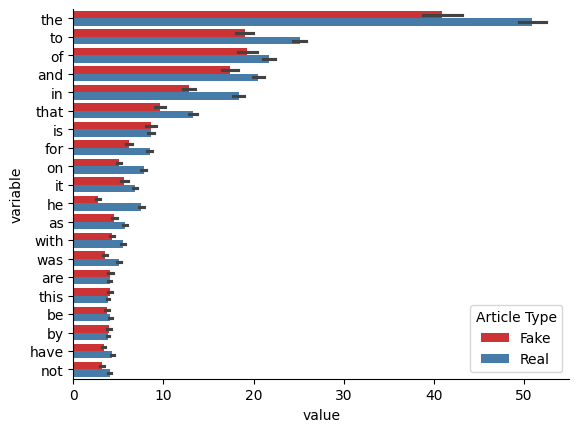

In [37]:
# Plot 20 most frequent words
df_word_probs_base = pd.DataFrame(X_counts.toarray(), columns=X_count_vect.get_feature_names_out())

n = 20
max_n_words = df_word_probs_base.mean(axis=0).sort_values(ascending = False).index[0:n]

df_word_probs_base = df_word_probs_base[max_n_words]
df_word_probs_base["label"] = ["Fake" if f == "FAKE" else "Real" for f in y_text]
df_word_probs_base = pd.melt(df_word_probs_base, id_vars="label")

g = sns.barplot(df_word_probs_base, y = "variable", x="value", hue="label", errorbar="ci", palette="Set1")
g.legend_.set_title("Article Type")
g.legend_.set_label(["Fake", "Real"])
sns.despine()

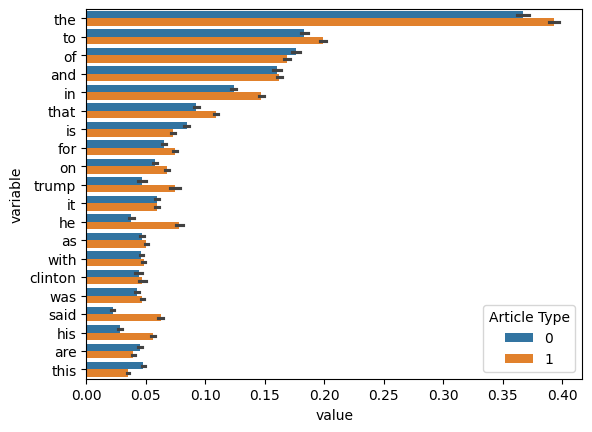

In [7]:
# plot 20 most frequent words by corrected frequency
df_word_probs_corrected = pd.DataFrame(X_tf.toarray(), columns=X_count_vect.get_feature_names_out())

max_n_words = df_word_probs_corrected.mean(axis=0).sort_values(ascending = False).index[0:n]

df_word_probs_corrected = df_word_probs_corrected[max_n_words]
df_word_probs_corrected["label"] = y
df_word_probs_corrected = pd.melt(df_word_probs_corrected, id_vars="label")

g = sns.barplot(df_word_probs_corrected, y = "variable", x="value", hue="label", errorbar="ci")
g.legend_.set_title("Article Type")
g.legend_.set_label(["Fake", "Real"])

## ML

In [8]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#X_train_count_vect = CountVectorizer()
X_train_counts = X_count_vect.transform(X_train)
X_train_tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = X_train_tf_transformer.transform(X_train_counts)

In [9]:
y_train.shape # 5000 samples in training set

(5068,)

In [10]:
rf_classifier = RandomForestClassifier()
rf_scores = cross_val_score(rf_classifier, X_train_tf, y_train, cv=20)
rf_classifier.fit(X_train_tf, y_train)

print(rf_scores.mean())


0.8976004481653233


In [11]:

kn_classifier = KNeighborsClassifier()
kn_scores = cross_val_score(kn_classifier, X_train_tf, y_train, cv=20)
kn_classifier.fit(X_train_tf, y_train)
print(kn_scores.mean())


0.8121603747160062


In [12]:

nb_classifier = MultinomialNB()
nb_scores = cross_val_score(nb_classifier, X_train_tf, y_train, cv=20)
nb_classifier.fit(X_train_tf, y_train)
print(nb_scores.mean())


0.856357567458218


In [13]:

lin_sv_classifier = SVC()
lin_sv_scores = cross_val_score(lin_sv_classifier, X_train_tf, y_train, cv=20)
lin_sv_classifier.fit(X_train_tf, y_train)
print(lin_sv_scores.mean())

0.9265903644455511


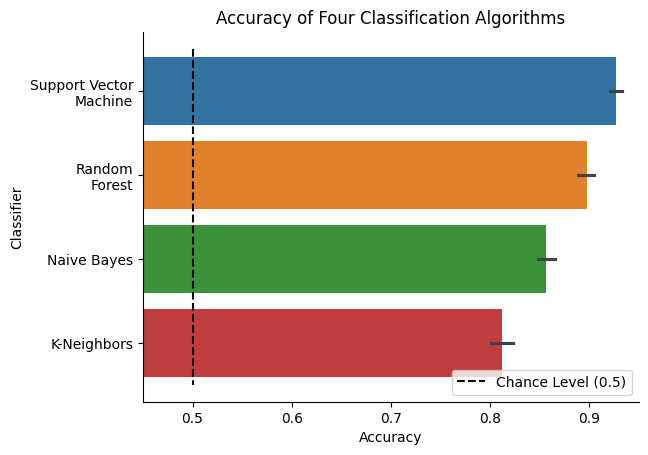

In [39]:
df_cv_scores = pd.DataFrame(np.array([lin_sv_scores, rf_scores, nb_scores, kn_scores]), 
    index=["Support Vector\nMachine", "Random\nForest", "Naive Bayes", "K-Neighbors"]).T
df_cv_scores = pd.melt(df_cv_scores)

#fig = plt.figure(figsize=(6.4, 4.8))
g = sns.barplot(df_cv_scores, y="variable", x="value", hue="variable", errorbar="ci")
#g.legend_.set_title("Classifier")
plt.vlines(x=0.5, ymin=-0.5, ymax=3.5, ls="--", colors="k", label = "Chance Level (0.5)")
g.set_ylabel("Classifier")
g.set_xlabel("Accuracy")
g.set_xlim([0.45, 0.95])
plt.legend(loc="lower right")
plt.title("Accuracy of Four Classification Algorithms")
#g.legend_.set_label(["Fake", "Real"])
sns.despine()

In [18]:
X_test_counts = X_count_vect.transform(X_test)
X_test_tf = X_train_tf_transformer.transform(X_test_counts)

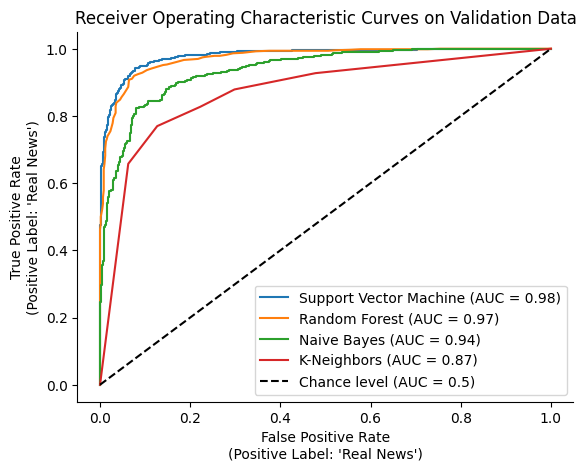

In [41]:
ax = plt.gca()
RocCurveDisplay.from_estimator(lin_sv_classifier, X_test_tf, y_test, ax=ax, name = "Support Vector Machine")
RocCurveDisplay.from_estimator(rf_classifier, X_test_tf, y_test, ax=ax, name = "Random Forest")
RocCurveDisplay.from_estimator(nb_classifier, X_test_tf, y_test, ax=ax, name = "Naive Bayes")
RocCurveDisplay.from_estimator(kn_classifier, X_test_tf, y_test, ax=ax, name = "K-Neighbors", plot_chance_level=True)
ax.set_xlabel("False Positive Rate\n(Positive Label: 'Real News')")
ax.set_ylabel("True Positive Rate\n(Positive Label: 'Real News')")
plt.title("Receiver Operating Characteristic Curves on Validation Data")
sns.despine()
plt.show()

In [20]:
print(lin_sv_classifier.score(X_test_tf, y_test))
print(rf_classifier.score(X_test_tf, y_test))
print(nb_classifier.score(X_test_tf, y_test))
print(kn_classifier.score(X_test_tf, y_test))

0.9297553275453828
0.9218626677190213
0.8634569850039463
0.8034727703235991


### Feature importance

In [21]:
# Permutation importance: randomly shuffle frequencies for each word and compare validation metric to baseline -> get approximation of 
# that words contribution to total accuracy
# Warning: slow, bc svc is slow

lin_sv_imps = permutation_importance(lin_sv_classifier, pd.DataFrame.sparse.from_spmatrix(X_test_tf), y_test,
                            n_repeats=10,
                            random_state=seed, n_jobs=14)

In [28]:
df_imp = pd.DataFrame(lin_sv_imps.importances.T, columns=X_count_vect.get_feature_names_out())

In [29]:
n = 20
n_most_imp = df_imp.median().sort_values(ascending=False)[0:n].index

In [30]:
df_imp_plot = df_imp[n_most_imp].melt()


In [31]:
df_imp_plot

,variable,value
0,2016,0.009471
1,2016,0.004736
2,2016,0.011050
3,2016,0.006314
4,2016,0.014996
...,...,...
195,says,-0.001579
196,says,0.001579
197,says,0.003157
198,says,0.003157


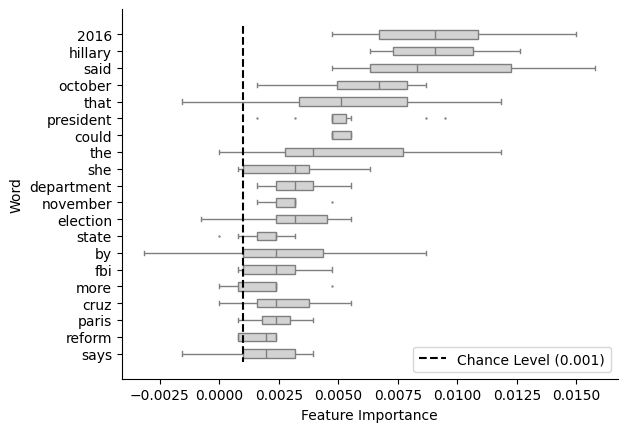

In [32]:
g = sns.boxplot(df_imp_plot, y = "variable", x="value", color="lightgrey", fliersize=0.7, width = 0.5)
g.set_ylabel("Word")
g.set_xlabel("Feature Importance")
plt.vlines(x=1/1000, ymin=-0.5, ymax=n-0.5, ls="--", colors="k", label="Chance Level (0.001)")
plt.legend(loc="lower right")
sns.despine()

/tmp/ipykernel_592451/2979231751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_imp["label"] = ["Fake" if f == "FAKE" else "Real" for f in y_text]


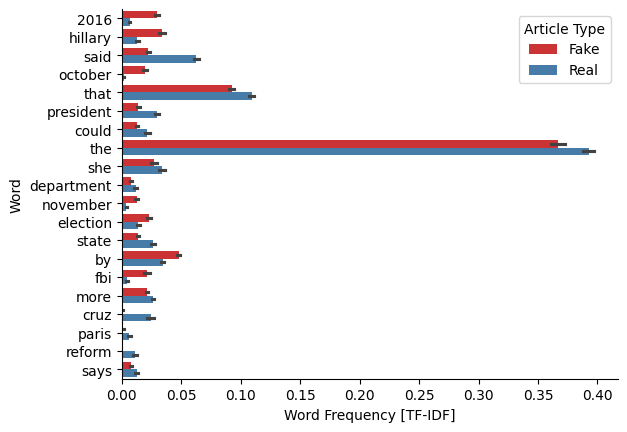

In [33]:
df_word_probs_corrected = pd.DataFrame(X_tf.toarray(), columns=X_count_vect.get_feature_names_out())

df_highest_imp = df_word_probs_corrected[n_most_imp]
df_highest_imp["label"] = ["Fake" if f == "FAKE" else "Real" for f in y_text]
df_highest_imp = pd.melt(df_highest_imp, id_vars="label")

g = sns.barplot(df_highest_imp, y = "variable", x="value", hue="label", errorbar="ci", palette="Set1")
g.legend_.set_title("Article Type")
g.legend_.set_label(("Fake", "Real"))

g.set_ylabel("Word")
g.set_xlabel("Word Frequency [TF-IDF]")

sns.despine()

In [34]:
#Same for random forest, much quicker
rf_imps = permutation_importance(rf_classifier, pd.DataFrame.sparse.from_spmatrix(X_test_tf), y_test,
                            n_repeats=100,
                            random_state=seed, n_jobs=15)

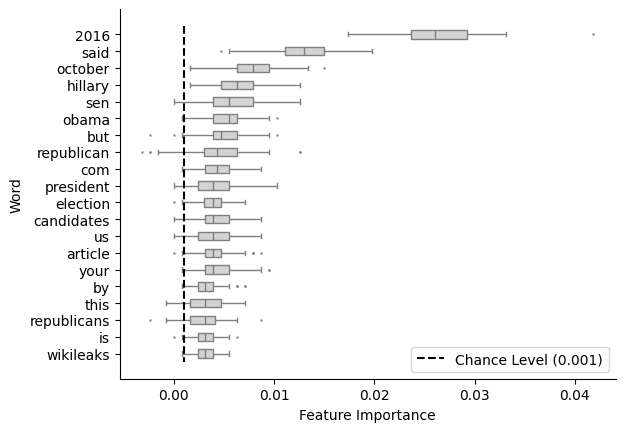

In [35]:
df_rf_imp = pd.DataFrame(rf_imps.importances.T, columns=X_count_vect.get_feature_names_out())

n = 20
n_most_imp_rf = df_rf_imp.median().sort_values(ascending=False)[0:n].index

df_rf_imp_plot = df_rf_imp[n_most_imp_rf].melt()

g = sns.boxplot(df_rf_imp_plot, y = "variable", x="value", color="lightgrey", fliersize=0.7, width = 0.5)
g.set_ylabel("Word")
g.set_xlabel("Feature Importance")
plt.vlines(x=1/1000, ymin=-0.5, ymax=n-0.5, ls="--", colors="k", label="Chance Level (0.001)")
plt.legend(loc="lower right")
plt.title("Importance of Word Frequencies")
sns.despine()

/tmp/ipykernel_592451/3791431846.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highest_imp["label"] = ["Fake" if f == "FAKE" else "Real" for f in y_text]


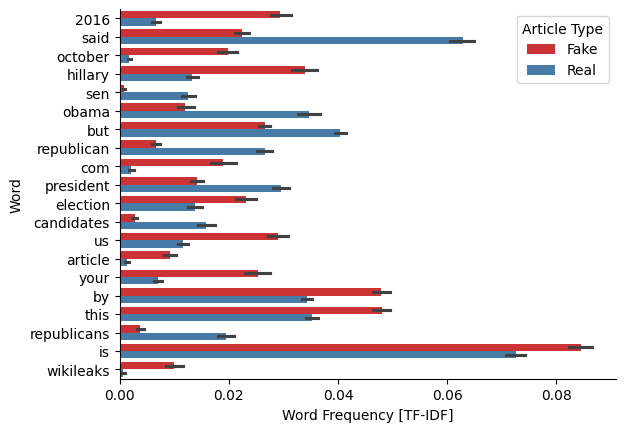

In [36]:
df_word_probs_corrected = pd.DataFrame(X_tf.toarray(), columns=X_count_vect.get_feature_names_out())

df_highest_imp = df_word_probs_corrected[n_most_imp_rf]
df_highest_imp["label"] = ["Fake" if f == "FAKE" else "Real" for f in y_text]
df_highest_imp = pd.melt(df_highest_imp, id_vars="label")

g = sns.barplot(df_highest_imp, y = "variable", x="value", hue="label", errorbar="ci", palette="Set1")
g.legend_.set_title("Article Type")
g.legend_.set_label(("Fake", "Real"))

g.set_ylabel("Word")
g.set_xlabel("Word Frequency [TF-IDF]")

sns.despine()